# Toy model of predictive coding network with phase synchronized oscillators 

Toy model of predictive coding network implemented in Nengo.
The error signal synchronizes receiver oscillator to the phase of master oscillator. Feedforward error signal becomes zero when finishing teaching receiver oscillator.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math 
import random

import nengo

In [2]:
# Parameters
tau_synapse = 0.2 # should be reasonably large
omega1 = 7 # frequency of master oscillator
omega2 = 8 # frequency of receiver oscillator
amp = 1 # amplitude of oscillations
gamma1 = 2 # energy precervation rate for oscillator 1
gamma2 = 4 # energy precervation rate for oscillator 2

k = 30 # synchronizing pulling force
gamma = 4 # synchronizing dissipation

## Construct network

In [8]:
model = nengo.Network()

with model:

    # the first two dimensions are "position" and "velocity"
    osc1 = nengo.Ensemble(n_neurons=500, dimensions=2, radius=1.5) # master oscillator
    osc2 = nengo.Ensemble(n_neurons=500, dimensions=2, radius=1.5) # receiver oscillator   
    err = nengo.Ensemble(n_neurons=100, dimensions=2) # population to calculate an error of "predicted" dynamics

    # forward error propagation
    def forward(err):
        return tau_synapse*(-(k/omega2)*err[1]-gamma*err[0]), 0
    
    nengo.Connection(osc1,err,transform=-1)
    nengo.Connection(err,osc2, function=forward, synapse=tau_synapse)
    nengo.Connection(osc2,err,transform=1) # feedback to the error population
    #nengo.Connection(osc2,err,transform=[-omega1/omega2,-1])
    

    def recurr1(x): # recurrent function for master oscillator
        return [-tau_synapse*omega1*x[1]-tau_synapse*gamma1*(x[0]**2+x[1]**2-amp**2)*x[0]+x[0], 
                 tau_synapse*omega1*x[0]+x[1]]    
    
    def recurr2(x): # recurrent function for receiver oscillator
        return [-tau_synapse*omega2*x[1]-tau_synapse*gamma2*(x[0]**2+x[1]**2-amp**2)*x[0]+x[0], 
                 tau_synapse*omega2*x[0]+x[1]]    
  
    nengo.Connection(osc1,osc1[:2], function=recurr1, synapse=tau_synapse)
    nengo.Connection(osc2,osc2[:2], function=recurr2, synapse=tau_synapse)   

    # Optional: additional kick-start with random phase
    def stim_func(t):
        phi = random.random()*math.pi
        if t < 0.1:
            return math.cos(phi), math.sin(phi)
        else:
            return 0, 0
        
    stim1 = nengo.Node(stim_func)
    stim2 = nengo.Node(stim_func)
    nengo.Connection(stim1, osc1)
    nengo.Connection(stim2, osc2)

## Add probes

In [9]:
with model:
    osc1_probe = nengo.Probe(osc1, synapse=0.01)
    osc2_probe = nengo.Probe(osc2, synapse=0.01)

## Run the model¶

In [13]:
# Create simulator
with nengo.Simulator(model) as sim:
    sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

## Plot the results

Plot the relative phase between two oscillators

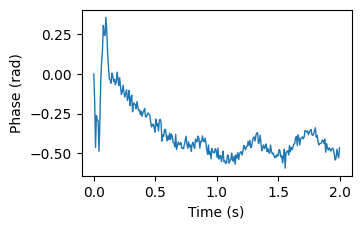

In [18]:
# Plot the decoded output of the ensemble
n = 7 # plot every n-th point
x = sim.trange()[::n]
y1 = sim.data[osc1_probe][::n]
y2 = sim.data[osc2_probe][::n]

# figure dimensions
width = 3.487
height = width / 1.618

phi1 = np.arctan2(y1[:,0], y1[:,1])
phi2 = np.arctan2(y2[:,0], y2[:,1])
diff_phi = phi2 - phi1
diff_phi[diff_phi>math.pi] -= 2*math.pi
diff_phi[diff_phi<-math.pi] += 2*math.pi
fig = plt.figure(figsize=(width,height))
plt.plot(x, diff_phi, linewidth=1)
plt.xlabel("Time (s)",  fontsize=10)
plt.ylabel("Phase (rad)", fontsize=10)

# save the figure if necessary
plt.savefig('PhaseSync.svg', bbox_inches='tight')

In [22]:
# save data for further use
import pickle

data = {'time': sim.trange(),
        'osc1_output': sim.data[osc1_probe].squeeze(),
        'osc2_output': sim.data[osc2_probe].squeeze()}

with open('PhaseSync.data', 'wb') as f:
        pickle.dump(data, f)

# load previously save data
# with open('PhaseSync.data', 'rb') as f:
#         data = pickle.load(f)

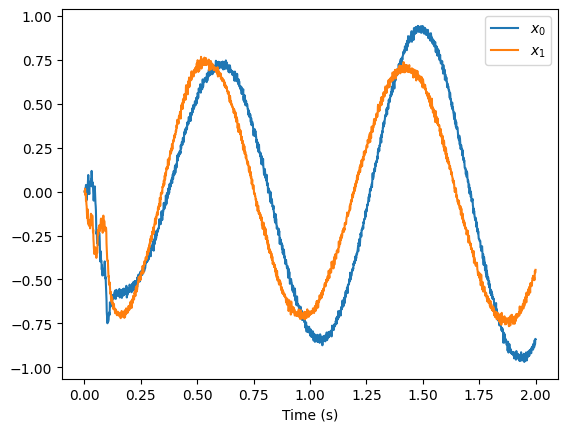

In [15]:
plt.figure()
plt.plot(sim.trange(), sim.data[osc1_probe][:,0], sim.trange(), sim.data[osc2_probe][:,0])
plt.xlabel("Time (s)")
plt.legend(["$x_0$", "$x_1$"])